<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_1/images/SN_web_lightmode.png" width="300"> 
</center>


<h1>Refine the Baseline Regression Models</h1>

Estimated time needed: **120** minutes


## Lab Overview:

Now you have built a baseline regression model with some relatively good RMSE and R-squared reported values. However, we could still improve it by using methods like adding polynomial and interaction terms, regularization, and so on.

In this lab, you will be asked to continue using `tidymodels` to improve the performance of baseline model:

- **TASK: Add polynomial terms**
- **TASK: Add interactions terms**
- **TASK: Add regularizations terms**
- **TASK: Experiment to search for improved models**


Let's start!


The tidyverse and the tidymodels packages can be used to produce high quality statistical and machine learning models. The Tidyverse library is a useful tool that provides various tools for data visualization, data manipulation, and read various datasets into a data frame; our Jupyter notebook platforms have a built-in Tidymodels, Tidyverse and rlang libraries, so we do not need to install these packages prior to loading library. However, if you decide to run this lab on your RStudio Desktop locally on your machine, you can remove the commented lines of code to install these packages before loading.


In [ ]:
# Uncomment to install packages if running locally
# install.packages("tidyverse")
# install.packages("tidymodels")

In [1]:
library("tidymodels")
library("tidyverse")
library("stringr")
library("glmnet")


── Attaching packages ────────────────────────────────────── tidymodels 0.1.0 ──
✔ broom     0.5.6      ✔ recipes   0.1.12
✔ dials     0.0.6      ✔ rsample   0.0.5 
✔ dplyr     0.8.5      ✔ tibble    3.0.1 
✔ ggplot2   3.3.0      ✔ tune      0.1.0 
✔ infer     0.5.1      ✔ workflows 0.1.1 
✔ parsnip   0.1.0      ✔ yardstick 0.0.6 
✔ purrr     0.3.4      
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard()  masks scales::discard()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ ggplot2::margin() masks dials::margin()
✖ recipes::step()   masks stats::step()
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ stringr 1.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter

The processed Seoul bike sharing dataset `seoul_bike_sharing_converted_normalized.csv`,  includes the converted indicator variables, and the numerical variables have been normalized. 
Let's read it as a dataframe first:


In [2]:
# Dataset URL
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url)
spec(bike_sharing_df)

Parsed with column specification:
cols(
  .default = col_double(),
  DATE = col_character(),
  FUNCTIONING_DAY = col_character()
)
See spec(...) for full column specifications.


cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

We won't be using the `DATE` column, because 'as is', it basically acts like an data entry index. (However, given more time, we could use the `DATE` colum to create a 'day of week' or 'isWeekend' column, which we might expect has an affect on preferred bike rental times.) We also do not need the `FUNCTIONAL DAY` column because it only has one distinct value remaining (`YES`) after missing value processing.


In [3]:
bike_sharing_df <- bike_sharing_df %>% 
                   select(-DATE, -FUNCTIONING_DAY)

Define a linear regression model specification.


In [4]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>% 
  set_mode("regression")

Split the data into training and testing datasets.


In [5]:
set.seed(1234)
data_split <- initial_split(bike_sharing_df, prop = 4/5)
train_data <- training(data_split)
test_data <- testing(data_split)

Now we are ready to refine the previous baseline regression model.


# TASK: Add polynomial terms


Linear regression models are the most suitable models to capture the linear correlations among variables. However, in real world data, many relationships may be non-linear.


For example, the correlation between `RENTED_BIKE_COUNT` and `TEMPERATURE` does not look like linear:


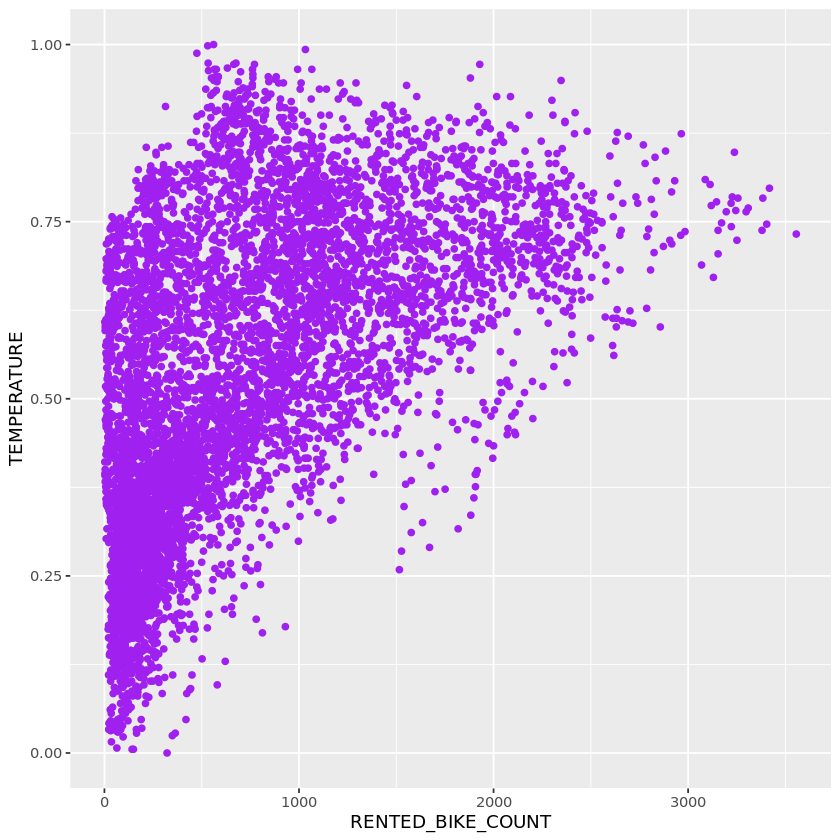

In [6]:
ggplot(data = train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point(color="purple") 

One solution to handle such nonlinearity is using polynomial regression by adding polynomial terms. As shown before, higher order polynomials are better than the first order polynomial.  

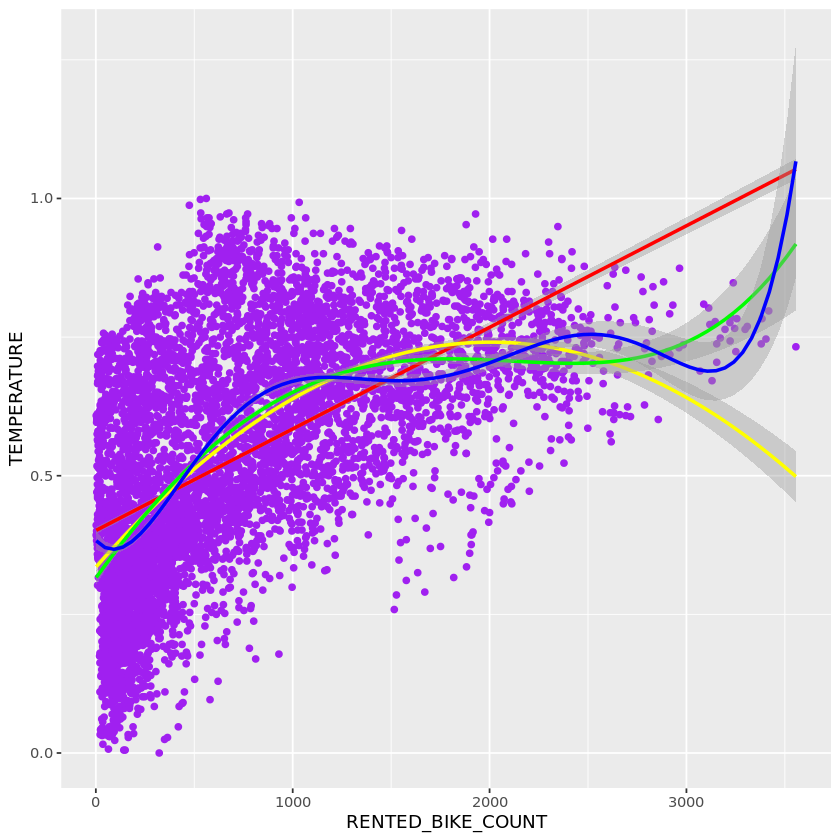

In [7]:
# Plot the higher order polynomial fits
ggplot(data=train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) + 
    geom_point(color="purple")  + 
    geom_smooth(method = "lm", formula = y ~ x, color="red") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 2), color="yellow") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 4), color="green") + 
    geom_smooth(method = "lm", formula = y ~ poly(x, 6), color="blue")

OK, let's add some higher order polynomials of important variables to the regression models


_TODO:_ Fit a linear regression model `lm_poly` with higher order polynomial terms on the important variables (larger coefficients) found in the baseline model


In [8]:
# Fit a linear model with higher order polynomial on some important variables 

# HINT: Use ploy function to build polynomial terms, lm_poly <- RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 6) + poly(HUMIDITY, 4) .....

lm_poly <- linear_reg(mode = "regression") %>%
  set_engine("lm") 
print(lm_poly)

lm_polyfit <- lm_poly %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) + poly(DEW_POINT_TEMPERATURE, 4), data = train_data)
print(lm_polyfit)

Linear Regression Model Specification (regression)

Computational engine: lm 

parsnip model object

Fit time:  60ms 

Call:
stats::lm(formula = formula, data = data)

Coefficients:
                    (Intercept)                      TEMPERATURE  
                         203.45                          1877.51  
                       HUMIDITY                       WIND_SPEED  
                        -483.40                             4.00  
                     VISIBILITY            DEW_POINT_TEMPERATURE  
                         -41.57                          -666.66  
                SOLAR_RADIATION                         RAINFALL  
                         -13.27                         -1171.14  
                       SNOWFALL                              `0`  
                         -99.67                           -71.79  
                            `1`                             `10`  
                        -179.20                          -181.18  
              

In [9]:
# Print model summary

summary(lm_polyfit)

        Length Class      Mode   
lvl      0     -none-     NULL   
spec     5     linear_reg list   
fit     12     lm         list   
preproc  1     -none-     list   
elapsed  5     proc_time  numeric

_TODO:_ Make predictions on test dataset using the `lm_poly` models


In [10]:
# Use predict() function to generate test results for `lm_poly`
lm_ploy_train_results <- lm_polyfit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

head(lm_ploy_train_results)

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”

.pred,truth
<dbl>,<dbl>
103.492035,254
-5.106321,204
-192.286368,107
-246.013611,100
216.829328,460
627.999728,930


Another minor improvement we could do here is to convert all negative prediction results to zero, because we can not have negative rented bike counts


In [11]:
# e.g., test_results[test_results<0] <- 0
lm_ploy_train_results$.pred <- replace(lm_ploy_train_results$.pred, lm_ploy_train_results$.pred < 0, 0)
lm_ploy_train_results

.pred,truth
<dbl>,<dbl>
103.4920349,254
0.0000000,204
0.0000000,107
0.0000000,100
216.8293278,460
627.9997284,930
0.0000000,339
0.3004057,360
138.2058772,451


Now, calculate R-squared and RMSE for the test results generated by `lm_ploy` model


In [12]:
# Calculate R-squared and RMSE from the test results
rsq_lm_ploy <- rsq(lm_ploy_train_results,
  truth = truth,
  estimate = .pred
)

rmse_lm_ploy <- rmse(lm_ploy_train_results,
  truth = truth,
  estimate = .pred
)

rsq_lm_ploy
rmse_lm_ploy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7556552


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,320.2715


If you include all variables, and additionally include some of the more important ones as higher order poly terms, then you should notice improved  `R-squared` and `RMSE` values.


# TASK: Add interaction terms


In real-world scenarios, in addition to non-linear relationships between response variables and predictor variables, you may also encounter relationships among variables called `interaction effects`.

For example, the effect of predictor variable `TEMPERATURE` on `RENTED_BIKE_COUNT` may also depend on other variables such as `HUMIDITY`, `RAINFALL`, or both (they `interact`) and the effect of `SEASON` on `RENTED_BIKE_COUNT` may also depend on `HOLIDAY`, `HOUR`, or both.

To capture such interaction effects, we could add some interaction terms such as `RAINFALL*HUMIDITY` to the regression model, similar to what we did with polynominal terms. In this task, you will explore and conduct some experiments to search for interaction terms which will improve the model performance.


_TODO:_ Try adding some interaction terms to the previous polynomial models.


In [13]:
# Add interaction terms to the poly regression built in previous step

# HINT: You could use `*` operator to create interaction terms such as HUMIDITY*TEMPERATURE and make the formula look like:
# RENTED_BIKE_COUNT ~ RAINFALL*HUMIDITY ...
lm_poly <- linear_reg(mode = "regression") %>%
  set_engine("lm") 
print(lm_poly)

lm_polyfit <- lm_poly %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) + poly(DEW_POINT_TEMPERATURE, 4) + RAINFALL * HUMIDITY + HUMIDITY * TEMPERATURE + AUTUMN * HOLIDAY + AUTUMN * `18` + AUTUMN * `19` + AUTUMN * `8`, data = train_data)
print(lm_polyfit)

Linear Regression Model Specification (regression)

Computational engine: lm 

parsnip model object

Fit time:  45ms 

Call:
stats::lm(formula = formula, data = data)

Coefficients:
                    (Intercept)                      TEMPERATURE  
                      -1817.302                         6105.808  
                       HUMIDITY                       WIND_SPEED  
                       3484.008                           -1.591  
                     VISIBILITY            DEW_POINT_TEMPERATURE  
                        -30.808                         -813.037  
                SOLAR_RADIATION                         RAINFALL  
                        -23.542                       -27770.250  
                       SNOWFALL                              `0`  
                       -298.482                          -72.621  
                            `1`                             `10`  
                       -181.617                         -183.247  
              

In [15]:
# Print model summary
summary(lm_polyfit)

        Length Class      Mode   
lvl      0     -none-     NULL   
spec     5     linear_reg list   
fit     12     lm         list   
preproc  1     -none-     list   
elapsed  5     proc_time  numeric

In [16]:
# Calculate R-squared and RMSE for the new model to see if performance has improved
lm_ploy_train_results <- lm_polyfit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)
head(lm_ploy_train_results)


lm_ploy_train_results$.pred <- replace(lm_ploy_train_results$.pred, lm_ploy_train_results$.pred < 0, 0)
head(lm_ploy_train_results)
rsq_lm_ploy <- rsq(lm_ploy_train_results,
  truth = truth,
  estimate = .pred
)

rmse_lm_ploy <- rmse(lm_ploy_train_results,
  truth = truth,
  estimate = .pred
)

rsq_lm_ploy
rmse_lm_ploy

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”

.pred,truth
<dbl>,<dbl>
96.695778,254
-7.942676,204
-195.160247,107
-251.592436,100
212.410332,460
544.554925,930


.pred,truth
<dbl>,<dbl>
96.69578,254
0.00000,204
0.00000,107
0.00000,100
212.41033,460
544.55493,930


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7614983


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,316.1131


# TASK: Add regularization


In previous tasks, you were asked to add polynominal and interaction terms to the model, aiming to capture nonlinearity and interaction effects between the predictor variables. Hopefully, your updated models have better R-squared and RMSE values.

However, adding these terms makes your model more complicated, more difficult to explain, and more likely to suffer from overfitting. To overcome these issues, one solution is to add regularization terms to your models.


When building the baseline model, we used the basic `lm` engine. In this task, you will use a more advanced and generalized `glmnet` engine. It provides a generalized linear model with Lasso, Ridge, and Elastic Net regularizations.

In general, using `glmnet` can enhance your models in the following ways:
- Address overfitting issues by shrinking the coefficients
- Address predictor variable colinearity by selecting only one variable from each group of colinear variables (by shrinking their coefficients to zero)
- Make your models more interpretable due to simplification (fewer variables in the outcome models)


Now, let's switch our regression engine to `glmnet`


_TODO:_ Define a linear regression model specification `glmnet_spec` using `glmnet` engine


In [ ]:
# HINT: Use linear_reg() function with two parameters: penalty and mixture
# - penalty controls the intensity of model regularization
# - mixture controls the tradeoff between L1 and L2 regularizations

# Create the formula for the model
lm_glmnet_formula <- formula(RENTED_BIKE_COUNT ~ TEMPERATURE + HUMIDITY + DEW_POINT_TEMPERATURE + RAINFALL + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) +poly(RAINFALL, 6))

# Define a k-fold cross-validation method
folds <- vfold_cv(train_data, v = 10)

# Define the model specification with tuned parameters
tune_spec <- linear_reg(penalty = tune(), mixture = tune()) %>%
  set_engine("glmnet")

# Grid workflow
wf <- workflow() %>%
  add_formula(lm_glmnet_formula)

# Define tuning values
lambda_tune <- grid_regular(
  levels = 50,
  penalty(range = c(0, 0.3))
)

mixture_tune <- grid_regular(
  levels = 50,
  mixture(range = c(0, 1))
)

mix_grid <- as.data.frame(c(lambda_tune, mixture_tune))
# bind_cols(lambda_tune, mixture_tune) 

# define grid search
grid <- tune_grid(
  wf %>% add_model(tune_spec),
  resamples = folds,
  grid = mix_grid
)

# print grid search results
show_best(grid, metric = "rmse")


Fit a glmnet model called  `lm_glmnet` using the `fit()` function. For the formula part, keep the polynominal and interaction terms you used in the previous task.


In [ ]:
# Fit a glmnet model using the fit() function

lm_glmnet <- linear_reg(mode = "regression", penalty =1.885863, mixture = 0.9183673) %>%
  fit(RENTED_BIKE_COUNT ~ . +TEMPERATURE + HUMIDITY + DEW_POINT_TEMPERATURE + RAINFALL + poly(TEMPERATURE, 6) + poly(HUMIDITY, 6) +poly(RAINFALL, 6), data = train_data)

# create test results

lm_glmnet_train_results <- lm_glmnet %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

head(lm_glmnet_train_results)


In [ ]:
# Report rsq and rmse of the `lm_glmnet` model

# assign zero value for negitave results
lm_glmnet_train_results$.pred <- replace(lm_glmnet_train_results$.pred, lm_glmnet_train_results$.pred < 0, 0)

# Calculate R-squared and RMSE from the test results
rsq_lm_glmnet <- rsq(lm_glmnet_train_results,
  truth = truth,
  estimate = .pred
)

rmse_lm_glmnet <- rmse(lm_glmnet_train_results,
  truth = truth,
  estimate = .pred
)

rsq_lm_glmnet
rmse_lm_glmnet

# TASK: Experiment to search for improved models


Now you understand some of the methods that you can use to try to improve your models.


_TODO:_ Experiment by building and testing at least five different models. For each of your experiments, include polynomial terms, interaction terms, and one of the three regularizations we introduced.


In [ ]:
# Build at least five different models using polynomial terms, interaction terms, and regularizations.

# Save their rmse and rsq values

# Model 1 - I will keep the lm_poly model created before.

# Model 2 - Top cor variables, polynomial top variable, interaction term & L2 regulaizations

model2 <- linear_reg(penalty = 0.02, mixture = 1) %>%
  set_engine("glmnet")
model2_fit <- model2 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + DEW_POINT_TEMPERATURE + SOLAR_RADIATION + SUMMER * `18` + HUMIDITY, data = train_data)

model2_train_results <- model2_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model2$.pred <- replace(model2_train_results$.pred, model2_train_results$.pred < 0, 0)

rsq_model2 <- rsq(model2_train_results,
  truth = truth,
  estimate = .pred
)

rmse_model2 <- rmse(model2_train_results,
  truth = truth,
  estimate = .pred
)

# Model 3 - Top cor variables, 2 polynomial top variable, interaction term & elastic regularization

model3 <- linear_reg(penalty = 0.02, mixture = 0.2) %>%
  set_engine("glmnet")
model3_fit <- model3 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + poly(DEW_POINT_TEMPERATURE, 6) + SOLAR_RADIATION + SUMMER * `18` + TEMPERATURE * HUMIDITY, data = train_data)

model3_train_results <- model3_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model3$.pred <- replace(model3_train_results$.pred, model3_train_results$.pred < 0, 0)

rsq_model3 <- rsq(model3_train_results,
  truth = truth,
  estimate = .pred
)

rmse_model3 <- rmse(model3_train_results,
  truth = truth,
  estimate = .pred
)

# Model 4 - Top cor variables,4 polynomial top variable, interaction term & elastic regularization

model4 <- linear_reg(penalty = 0.0015, mixture = 0.2) %>%
  set_engine("glmnet")
model4_fit <- model4 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + poly(DEW_POINT_TEMPERATURE, 6) + poly(SOLAR_RADIATION, 6) + SUMMER * `18` + TEMPERATURE * HUMIDITY + poly(HUMIDITY, 6), data = train_data)

model4_train_results <- model4_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model4$.pred <- replace(model4_train_results$.pred, model4_train_results$.pred < 0, 0)

rsq_model4 <- rsq(model4_train_results,
  truth = truth,
  estimate = .pred
)

rmse_model4 <- rmse(model4_train_results,
  truth = truth,
  estimate = .pred
)

# Model 5 - Top cor variables,5 polynomial top variable, interaction term & elastic regularization

model5 <- linear_reg(penalty = 0.0015, mixture = 0.2) %>%
  set_engine("glmnet")
model5_fit <- model5 %>%
  fit(RENTED_BIKE_COUNT ~ . + poly(TEMPERATURE, 6) + WINTER * `18` + poly(DEW_POINT_TEMPERATURE, 6) + poly(SOLAR_RADIATION, 6) + poly(VISIBILITY, 6) + SUMMER * `18` + TEMPERATURE * HUMIDITY + poly(HUMIDITY, 6) + RAINFALL * TEMPERATURE + SNOWFALL * TEMPERATURE + RAINFALL * HUMIDITY + SNOWFALL * HUMIDITY, data = train_data)

model5_train_results <- model5_fit %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$RENTED_BIKE_COUNT)

model5_train_results$.pred <- replace(model5_train_results$.pred, model5_train_results$.pred < 0, 0)

rsq_model5 <- rsq(model5_train_results,
  truth = truth,
  estimate = .pred
)

rmse_model5 <- rmse(model5_train_results,
  truth = truth,
  estimate = .pred
)

# Save their rmse and rsq values

rsq_lm_ploy
rmse_lm_ploy
rsq_model2
rmse_model2
rsq_model3
rmse_model3
rsq_model4
rmse_model4
rsq_model5
rmse_model5


# Report the best performed model in terms of rmse and rsq
model 5

Here are the performance requirements for your best model:
- The RMSE should be less than 330 (rougly 10% of the max value in test dataset)
- R-squared should be greater than 0.72


_TODO:_ Visualize the saved RMSE and R-squared values using a grouped barchart


In [ ]:
# HINT: Use ggplot() + geom_bar()

model_names <- c("lm_ploy", "model2", "model3", "model4", "model5")
rsq <- c("0.7614983", "0.7137937", "0.7392157", "0.7674439", "0.7817489")
rmse <- c("316.1131", "344.91", "329.24", "310.9102", "302.1648")
comparison_df <- data.frame(model_names, rsq, rmse)

comparison_df %>%
  pivot_longer(!model_names) %>%
  ggplot(aes(x = model_names, y = value, fill = name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Comparing RSME AND RSQ Across Models", fill = "Metric")


_TODO:_ Create a Q-Q plot by plotting the distribution difference between the predictions generated by your best model and the true values on the test dataset.


In [ ]:
# HINT: Use ggplot() +
    # stat_qq(aes(sample=truth), color='green') +
    # stat_qq(aes(sample=prediction), color='red')
ggplot(model5_train_results) +
  stat_qq(aes(sample = truth), color = "green") +
  stat_qq(aes(sample = .pred), color = "red")

One example of such Q-Q plot may look like this:


<a href="https://cognitiveclass.ai/">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_4/images/example_qq_plot.png" width="600" align="center">
</a>


# More model improvment methods beyond this course


In addition to the methods mentioned in this lab and previous data analysis courses, you could also explore to try the following methods yourself to see if they could improve model performance:
 - Remove potential redundant variables. If two variables have extremly high correlated, it is possible that they are redundant and could be removed from the model to improve the performance.
 - Remove some outliers. Linear regression models are very sensitive to outliers, you could try to remove some outliers to see if it would improve performance
 - Apply logarithm transformation. In case variable distributions are not normal distribution such as log-normal distribution, you could apply logaritm transformation on the variable to make them more look like normal distribution. In addition, logarithm transformation helps capture the non-linear relationships.
 
If you have time, you could research and try more methods by searching related research papers/articles, discussion forums, etc. If you know how to use other machine learning models with `Tidymodels` such as Neural Networks, Tree models, or Boosting models, you can also try and compare them with the linear regression models.


# Next Steps:


Great! You have improved your baseline model using polynomial terms, interaction terms, and regularizations, and have found your best model.

Now it's time to build an interactive dashboard to provide more interactive user-interactions.


## Authors

<a href="https://www.linkedin.com/in/yan-luo-96288783/" target="_blank">Yan Luo</a>


### Other Contributors

Jeff Grossman


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description           |
| ----------------- | ------- | ---------- | ---------------------------- |
| 2021-04-08        | 1.0     | Yan        | Initial version created      |
|                   |         |            |                              |
|                   |         |            |                              |

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>
